<a href="https://colab.research.google.com/github/ravellys/PID/blob/master/Lista9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade \#9 - Filtragens espaciais com derivadas
---
## Universidade Federal de Pernambuco - Departamento de Energia Nuclear
## Processamento de Imagens Digitais
### Aluno - Lucas Ravellys
---

In [ ]:
# Importando bibliotecas
import skimage as sk
import matplotlib.pyplot as plt
import imageio
import numpy as np
import os
from matplotlib import image
import cv2

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip install numba

# Adaptive Median Filter

from numba import njit,prange
import numpy as np

@njit
def padding(img, pad):
    padded_img = np.zeros((img.shape[0]+2*pad,img.shape[1]+2*pad))
    padded_img[pad:-pad,pad:-pad] = img
    return padded_img

@njit(parallel=True)
def AdaptiveMedianFilter(img,s=3,sMax=7):
    if len(img.shape) == 3:
        raise Exception ("Single channel image only")

    H,W = img.shape
    a = sMax//2
    padded_img = padding(img,a)

    f_img = np.zeros(padded_img.shape)

    for i in prange(a,H+a+1):
        for j in prange(a,W+a+1):
            value = Lvl_A(padded_img,i,j,s,sMax)
            f_img[i,j] = value

    return f_img[a:-a,a:-a] 

@njit
def Lvl_A(mat,x,y,s,sMax):
    window = mat[x-(s//2):x+(s//2)+1,y-(s//2):y+(s//2)+1]
    Zmin = np.min(window)
    Zmed = np.median(window)
    Zmax = np.max(window)

    A1 = Zmed - Zmin
    A2 = Zmed - Zmax

    if A1 > 0 and A2 < 0:
        return Lvl_B(window, Zmin, Zmed, Zmax)
    else:
        s += 2 
        if s <= sMax:
            return Lvl_A(mat,x,y,s,sMax)
        else:
             return Zmed

@njit
def Lvl_B(window, Zmin, Zmed, Zmax):
    h,w = window.shape

    Zxy = window[h//2,w//2]
    B1 = Zxy - Zmin
    B2 = Zxy - Zmax

    if B1 > 0 and B2 < 0 :
        return Zxy
    else:
        return Zmed

In [ ]:
from tqdm import tqdm
def import_file(path):
  list_files = os.listdir(path) # lista de arquivos dentro da pasta das amostras
  list_files = np.sort(np.array(list_files)) # organizar os arquivos
  im = [] # inicialização do vetor de armazenamento

  for file in tqdm(list_files) :
    fetch_file = os.path.join(path, file)  
    image = np.array(imageio.imread(fetch_file)) # importa imagem e converte em numpy
 
    im.append(image.T) # Adiciona matriz numpy ao vetor de armazenameto

  im = np.array(im)
  return im[:,:,:].T  

In [ ]:
from skimage import exposure

# Plotagem Imagem + Histograma
def plot_im_hist(im, bits = 8):
  fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
  ax = axes.ravel()
  ax_cdf = ax[1].twinx()

  ax[0].imshow(im, cmap='gray', vmin =  0, vmax = 2**bits-1)
  ax[0].set_title('Image')
  ax[0].axis('off')

  ax[1].hist(im.ravel(), bins=(im.max()-im.min()), range = (0,  2**bits-1), density = True)
  ax[1].set_title('Histogram')

  img_cdf, bins = exposure.cumulative_distribution(im, nbins = 2**bits )
  ax_cdf.plot(bins, img_cdf, 'r')
  ax_cdf.set_yticks([])

  ax[1].grid(True)
  plt.show()

# Plota várias imagens
def plot_comp_image(ncols, titles, images, figsize = (12,24)): 
  n_images = len(images)

  fig, ax = plt.subplots(ncols = ncols, nrows = round(n_images/ncols), figsize = (30,120))
  ax = ax.ravel()

  for ax_,img, title in zip(ax,images,titles): 
    ax_.imshow(img,"gray", vmin =  0, vmax = 255)
    ax_.set_title(title)
    ax_.axis('off')

# Plota imagem e secção horizontal
def im_sec_plot(img, pos=100, bits=8):
  leny,lenx = img.shape
  line = img[pos,:]

  x = np.linspace(0,len(line),len(line))
  fig,ax = plt.subplots(ncols=2, figsize = (15,7))
  ax = ax.ravel()

  ax[0].plot(x,line)
  ax[0].grid()

  ax[1].imshow(img,"gray", vmin =  0, vmax = 2**bits)
  ax[1].hlines(pos, 0, lenx,color = 'red')
  ax[1].set_xlim(0, lenx)

  plt.show()    

#plota imagem
def plot_im(im, im_bin, thresh, pos = 4):   
  fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
  ax = axes.ravel()
  ax[0] = plt.subplot(1, 3, 1)
  ax[1] = plt.subplot(1, 3, 2)
  ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

  ax[0].imshow(im[:,:, pos], cmap=plt.cm.gray)  
  ax[0].set_title('Original')
  ax[0].axis('off')

  ax[1].hist(im.ravel(), bins=2**8)
  ax[1].set_title('Histogram')
  ax[1].axvline(thresh, color='r')

  ax[2].imshow(im_bin[:, :, pos], cmap=plt.cm.gray)
  ax[2].set_title('Thresholded')
  ax[2].axis('off')

  plt.show()

#altera range dos tons de cinza
def im_alt_range(im, n_min=0, n_max=255):
  min = im.min()
  max = im.max()
  im_ = n_min +(im - min)*(n_max - n_min)/(max - min)
  return im_.astype(int)   

## 1) Use as imagens DiversosObjetos.jpg, Lua.jpg e ct_escura.jpg para reproduzir os exemplos de filtros de derivadas (faça também os gráficos dos perfis) da aula 11, comentando os resultados obtidos nas filtragens implementadas.


In [ ]:
from skimage import io
dir = 'drive/My Drive/Classroom/Processamento de Imagens Digitais (1)/Processamento de Imagens Digitais/PID-Aula11/'
fils = os.listdir(dir)
list_imgs = [(io.imread(os.path.join(dir,file_),as_gray=True)*255).astype(dtype=np.uint8) for file_ in fils if file_[-3:] == 'jpg' ]

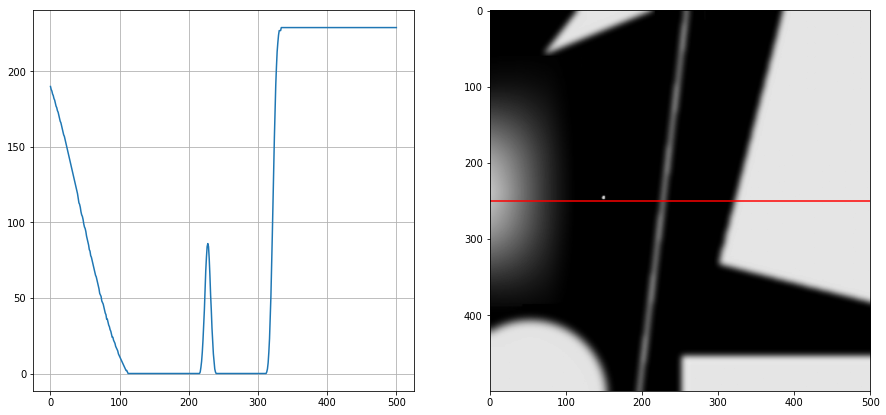

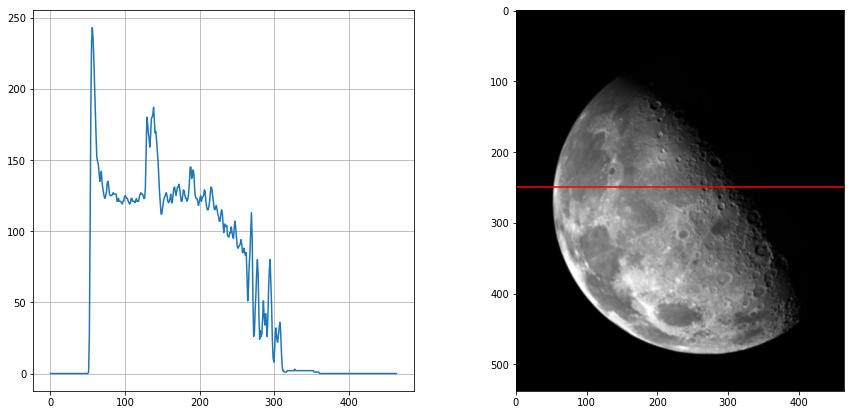

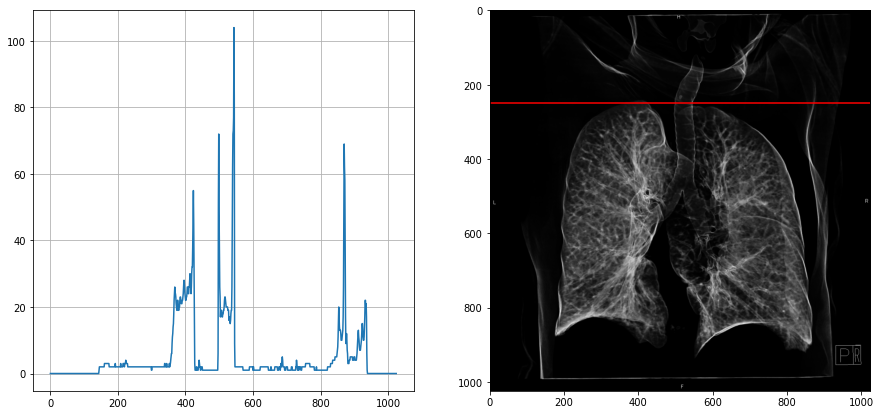

In [ ]:
for im in list_imgs:
  im_sec_plot(im,pos = 250)

filtro de adição 


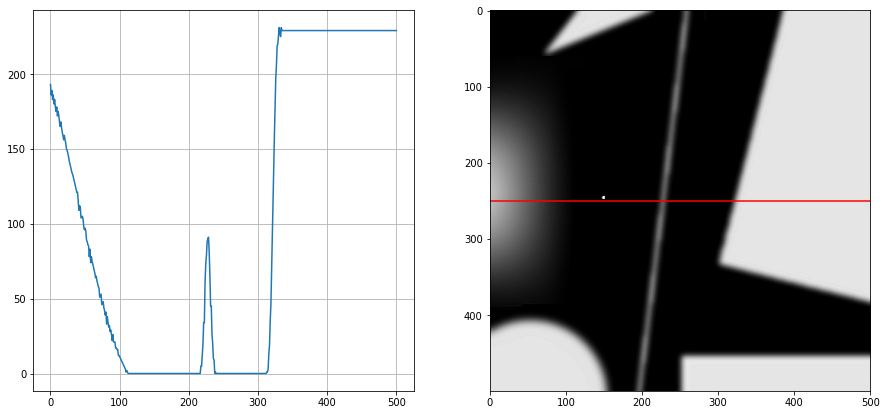

filtro de subtração 


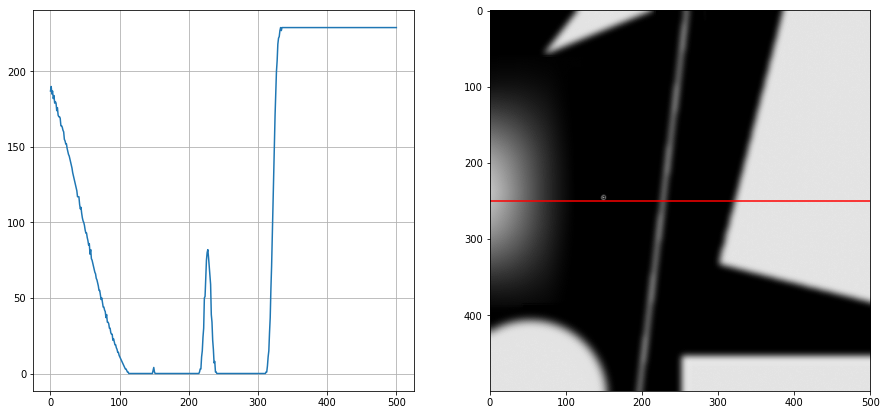

filtro de composição 


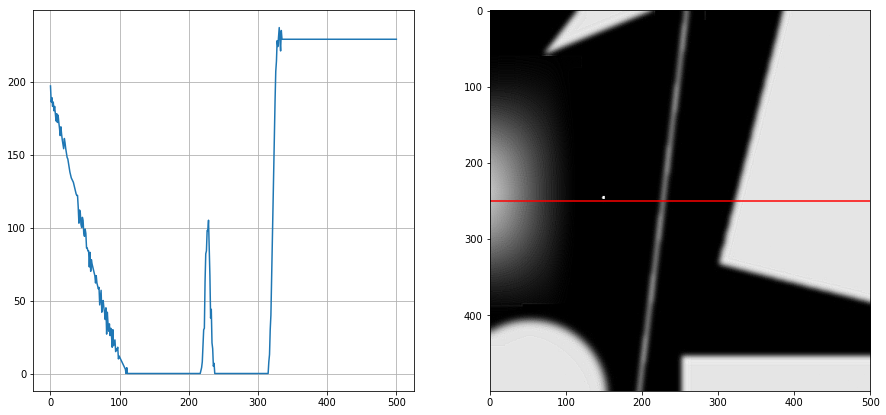

filtro de Impulso 1 


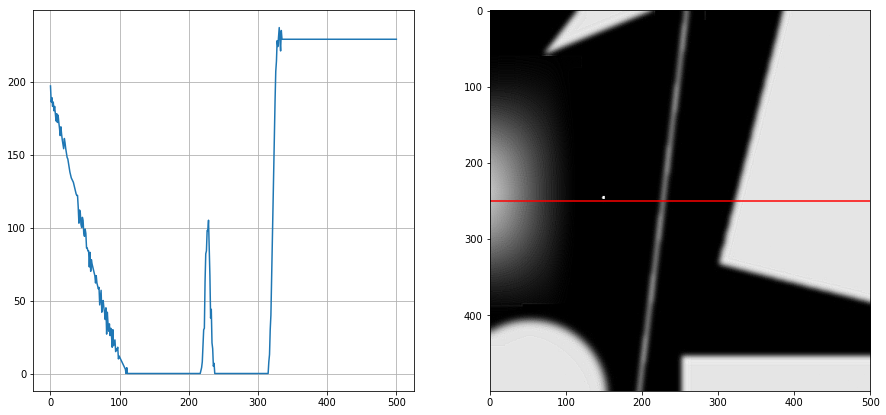

filtro de Impulso 1.5 


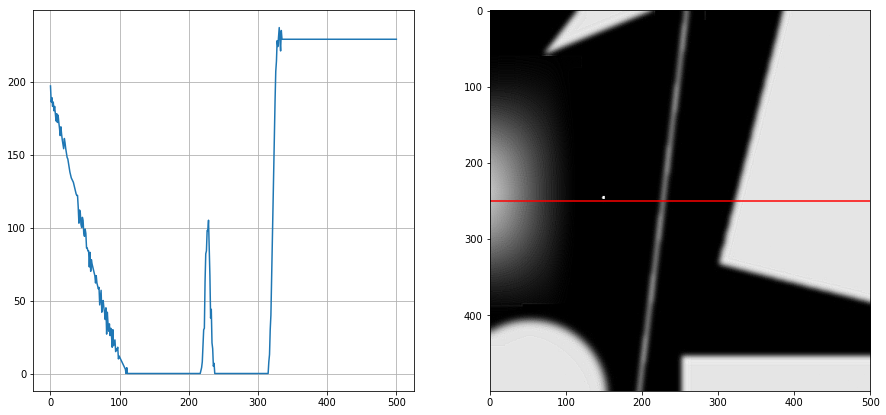

filtro de Impulso 2 


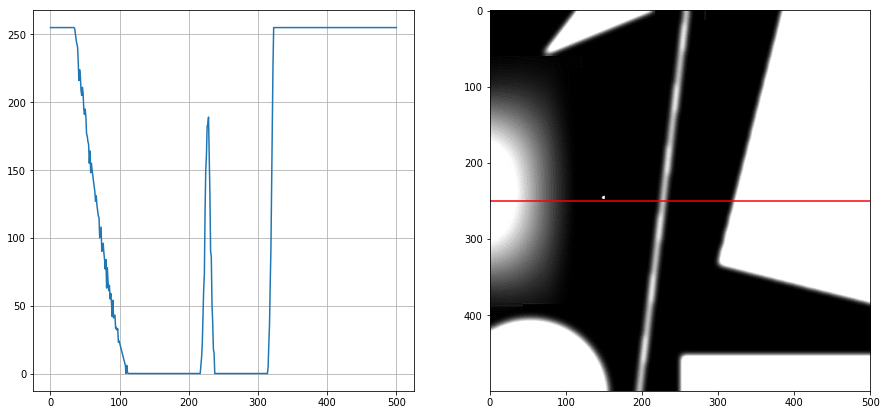

filtro de adição 


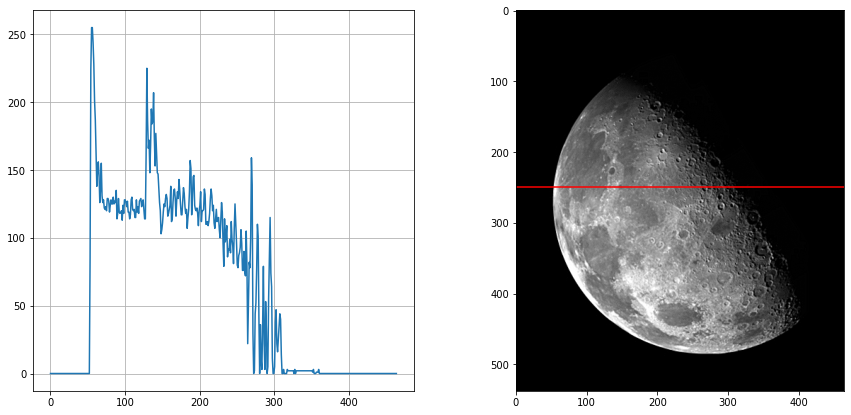

filtro de subtração 


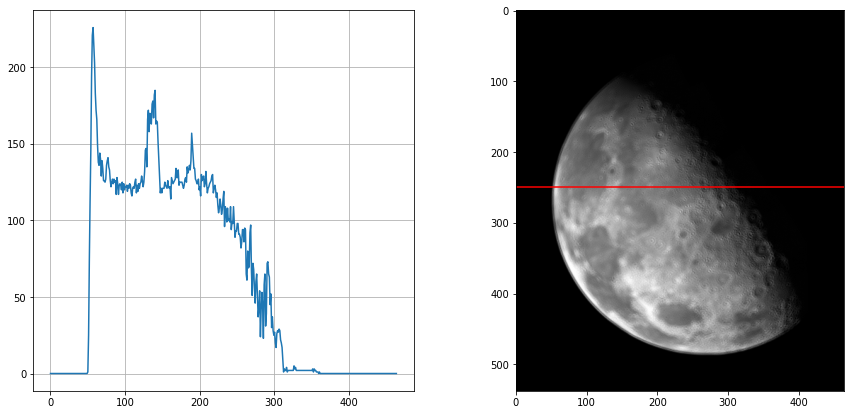

filtro de composição 


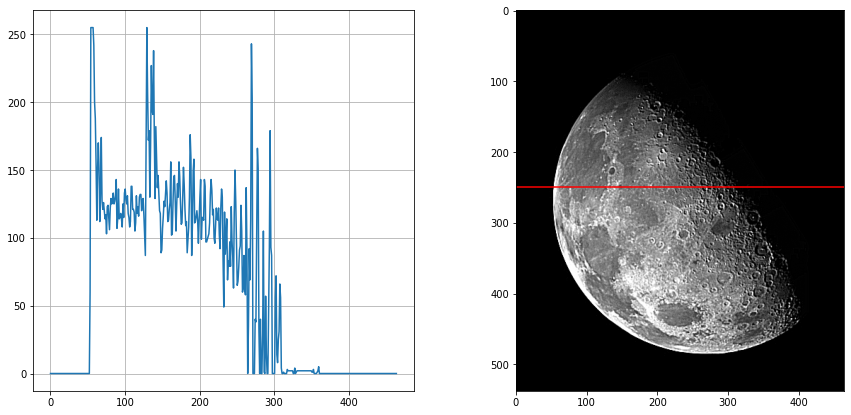

filtro de Impulso 1 


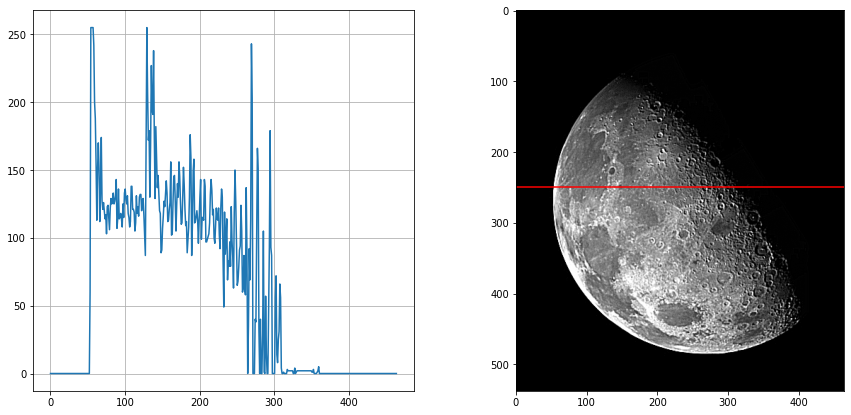

filtro de Impulso 1.5 


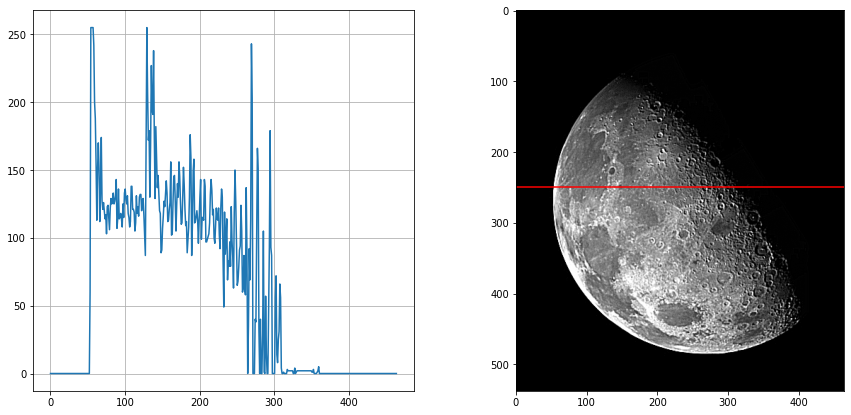

filtro de Impulso 2 


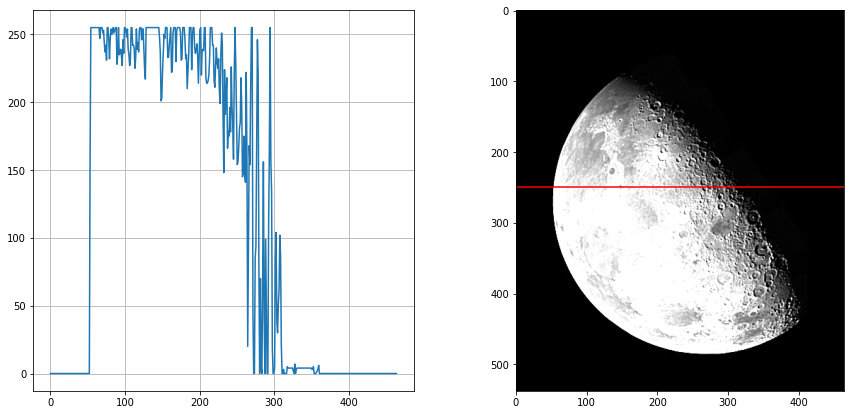

filtro de adição 


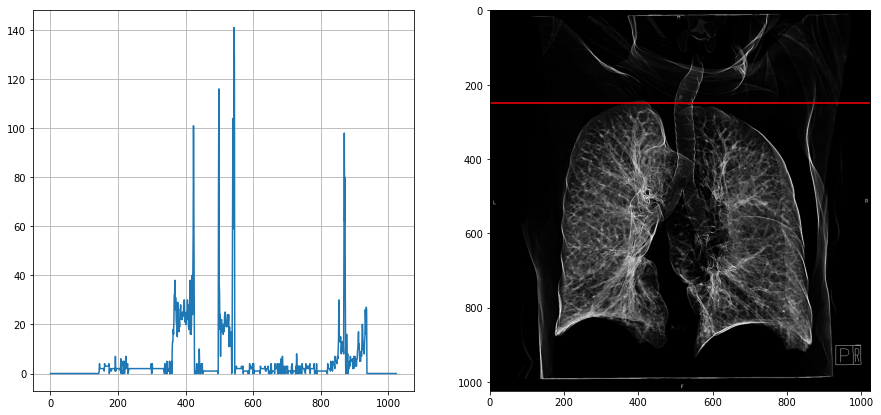

filtro de subtração 


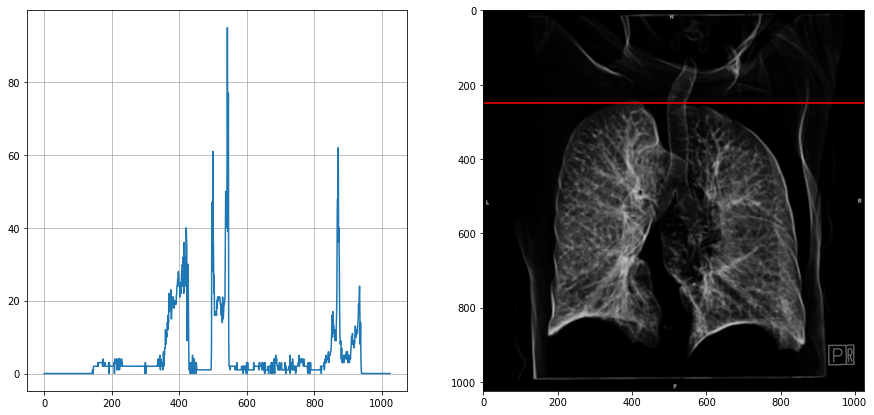

filtro de composição 


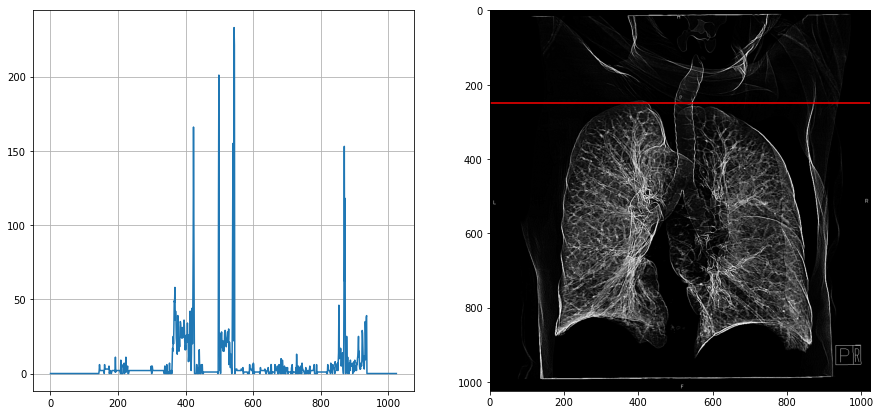

filtro de Impulso 1 


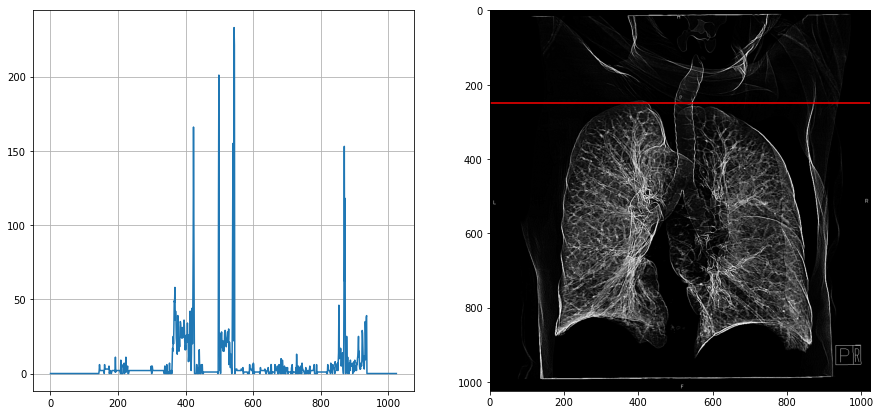

filtro de Impulso 1.5 


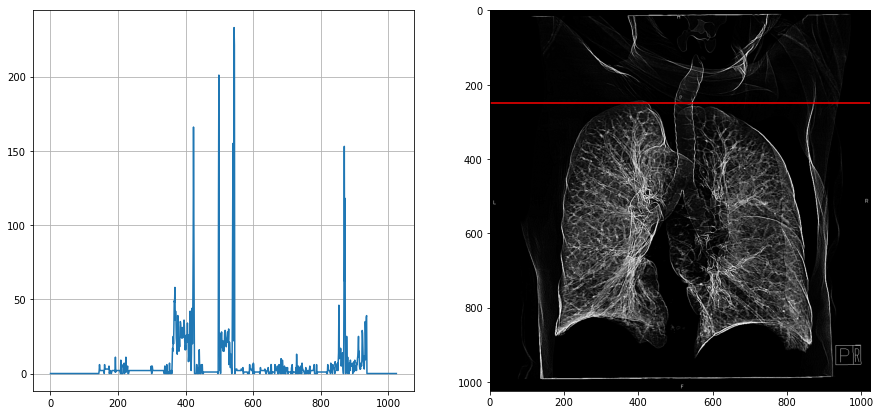

filtro de Impulso 2 


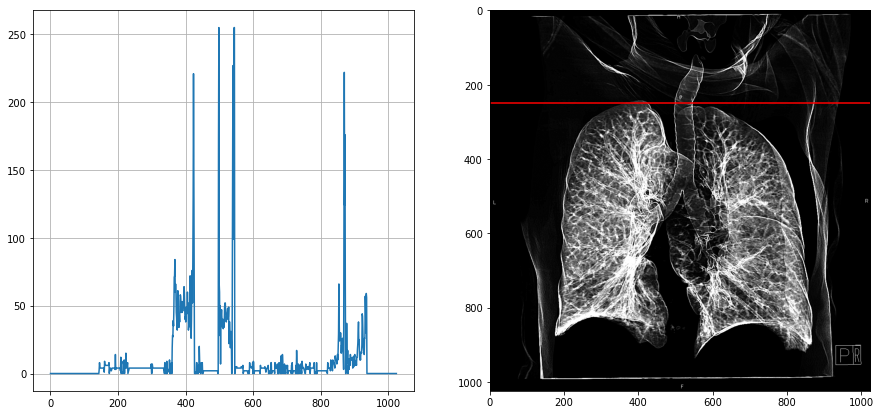

In [ ]:
from scipy.ndimage import convolve
from skimage import img_as_float

class ImageProcess:
  def __init__(self, im):
    self.im = img_as_float(im)

  def aplica_filtro(self, filtro, limita=True):
    im_ = convolve(self.im, filtro)
    if limita:
      im_[im_<0] = 0
      im_[im_>1] = 1
    return im_

FILT_ADD = np.array([[0, -1, 0],
                     [-1, 5, -1],
                     [0, -1, 0]])
FILT_SUB = np.array([[0, 1, 0],
                     [1,-3, 1],
                     [0, 1, 0]])
FILT_COMP = np.array([[-1, -1, -1],
                      [-1,  9, -1],
                      [-1, -1, -1]])

def filt_A(a):
  a_ = np.zeros_like(FILT_COMP)
  a_[1,1] = a - 1
  return FILT_COMP + a_

def plot_filtros(im):
  list_filt = [FILT_ADD, FILT_SUB, FILT_COMP]
  list_name = ['adição', 'subtração', 'composição']
  a_filts = [1,1.5,2]

  for a in a_filts:
    list_filt.append(filt_A(a))
    list_name.append(f"Impulso {a}")

  for name, filt in zip(list_name, list_filt):
    im_pr = ImageProcess(im)
    print(f"filtro de {name} ")
    im_sec_plot(im_pr.aplica_filtro(filt)*255, pos = 250)

for im in list_imgs: 
  plot_filtros(im)


Percebe-se que os resultados levaram a um contorno muito mais fino que o filtro gradiente. Inclusive diminuíram os tons de cinza nos detalhes contornados. O filtro de Impulso ainda clareou mais as imagens.

## 2) Use a imagem Lente.jpg para reproduzir os exemplos de filtros de derivadas (faça também os gráficos dos perfis) da aula 12, comentando os resultados obtidos na filtragem implementada.

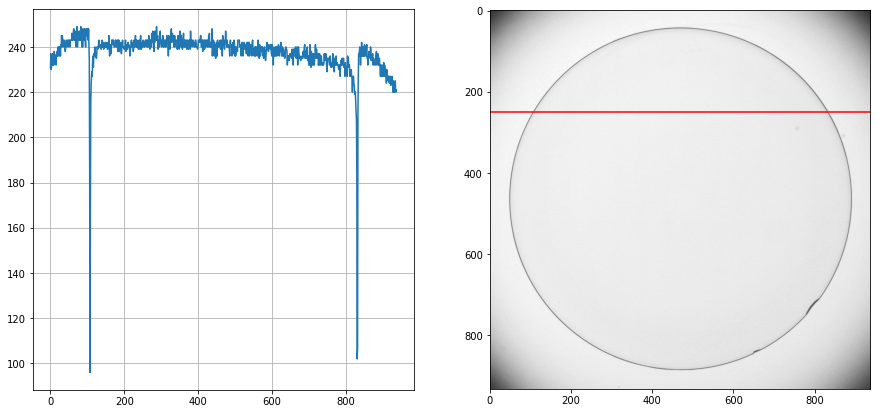

In [ ]:
#importando imagem
from skimage import io
file_ = 'drive/My Drive/Classroom/Processamento de Imagens Digitais (1)/Processamento de Imagens Digitais/PID-Aula12/Lente.jpg'
im_lnt = (io.imread(file_,as_gray=True)*255).astype(dtype=np.uint8)
im_sec_plot(im_lnt,pos = 250)

filtro de adição 


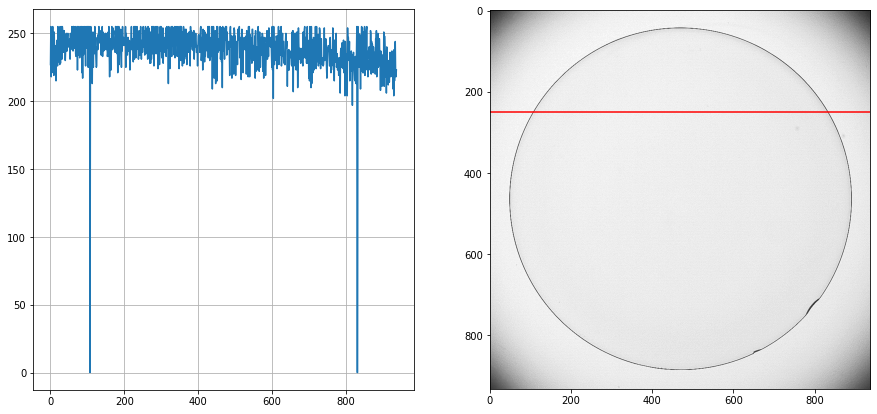

filtro de subtração 


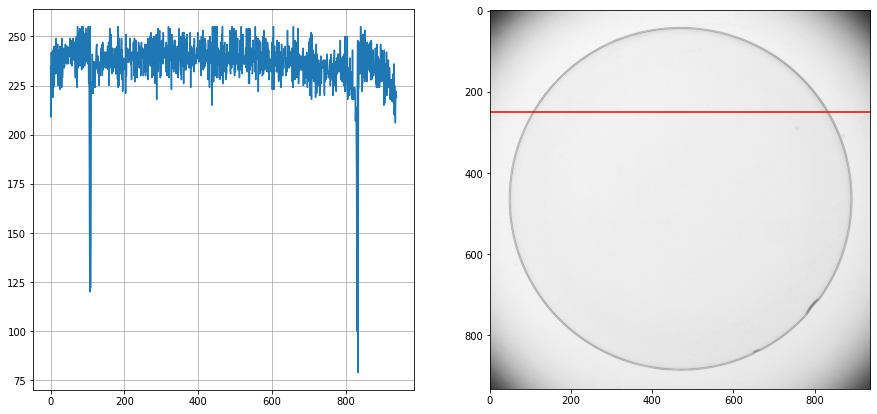

filtro de composição 


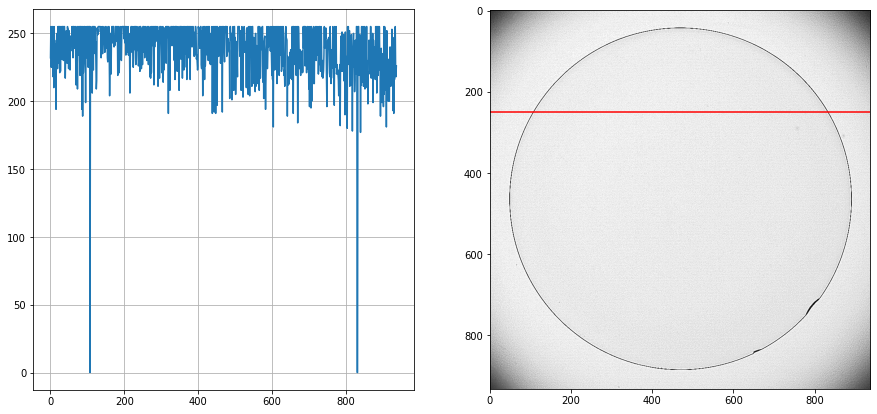

filtro de Impulso 1 


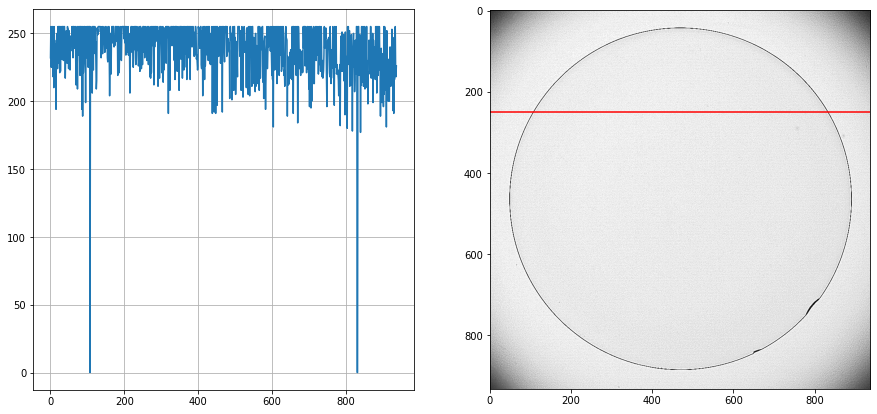

filtro de Impulso 1.5 


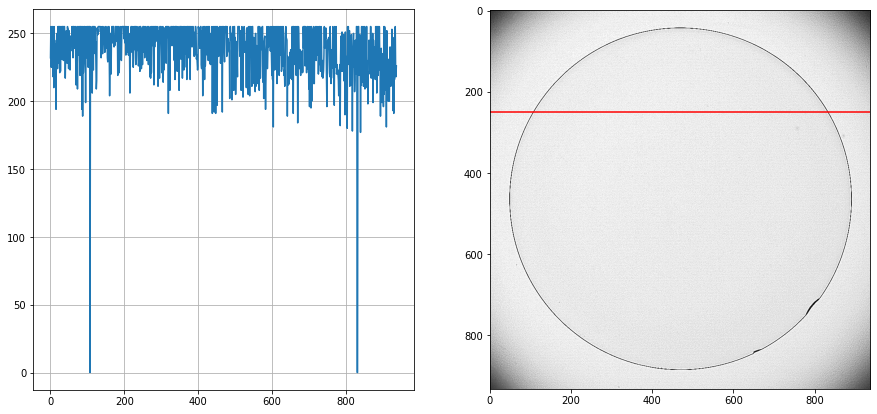

filtro de Impulso 2 


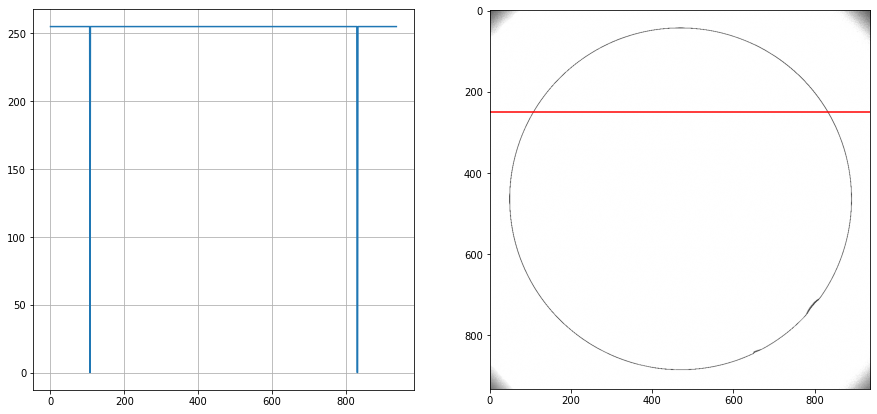

In [ ]:
plot_filtros(im_lnt)

Nota-se que os filtros apresentaram um bom desempenho em caracterizar o contorno das imagens



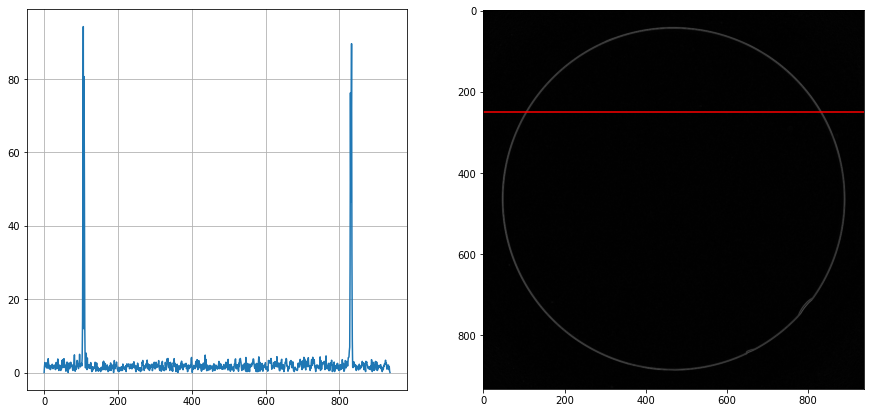

In [ ]:
from skimage import filters

im_sobel = filters.sobel(im_lnt)
im_sec_plot(255*im_sobel,pos = 250)

Na imagem gerada por Sobel nota-se uma maior nitidez em encontrar o contorno da lente.

## 3) Usando o conjunto de imagens micro-CT do fêmur de um adulto, reproduza todos os passos da aula 12 até obter dois blocos SGI segmentados com 15,24% de osso trabecular. Se necessário, use parâmetros e/ou filtros alternativos aos usados na aula, justificando-os.


Essa questão foi realizada utilizando uma amostra de neossolo regolitico do município de garanhuns

In [ ]:
#importa conjunto de imagens
path = 'drive/My Drive/Artigo Segmentação/Imagens/CM17P2A1_50gHu' #pasta da amostra
im = import_file(path)
print(im.shape)

100%|██████████| 840/840 [00:37<00:00, 22.17it/s]


(840, 840, 840)


In [ ]:
#seleção da amostra 200x100x160
def im_recort(im,x,y,z):
  x_size,y_size,z_size = im.shape
  s_x,s_y,s_z = np.array([(x_size-x)/2,(y_size-y)/2,(z_size-z)/2]).astype(int)
  e_x,e_y,e_z = np.array([x_size-(x_size-x)/2,y_size-(y_size-y)/2,z_size-(z_size-z)/2]).astype(int)

  return im[s_x:e_x,s_y:e_y,s_z:e_z]

im = im_recort(im, 200, 100, 160)

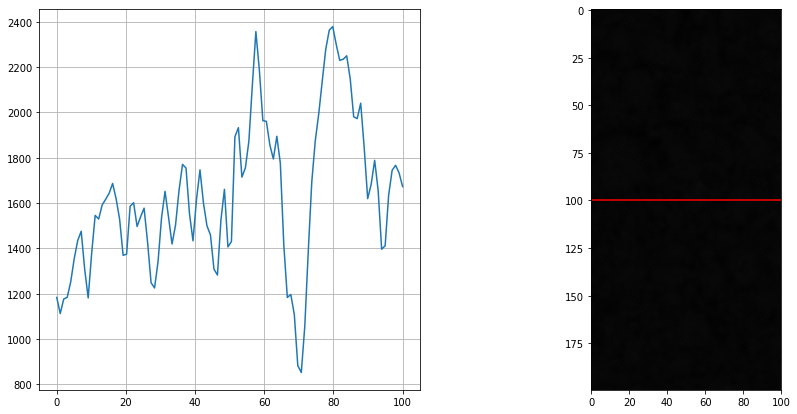

In [ ]:
# plot do slice 50 da amostra
im_sec_plot(im[:,:,50], pos=100, bits=16)

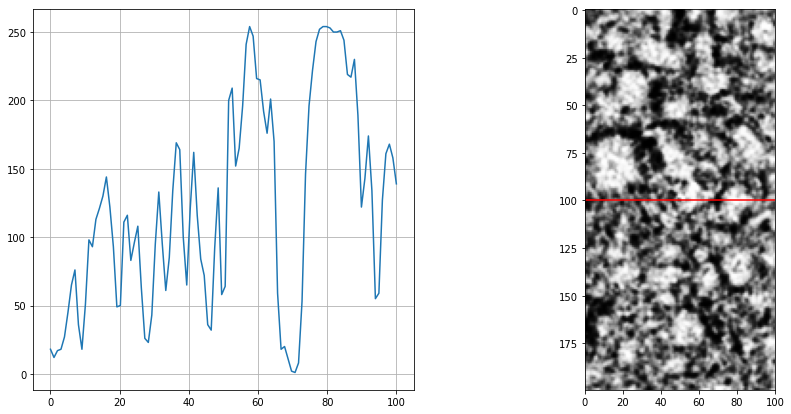

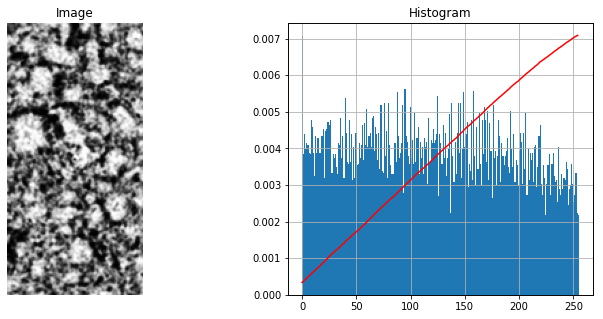

In [ ]:
from skimage import exposure

im_eq = exposure.equalize_hist(im)
im_eq = im_alt_range(im_eq,0,2**8-1)

# plot do slice 50 da amostra
im_sec_plot(im_eq[:,:,50], pos=100, bits=8)
plot_im_hist(im_eq[:,:,50])

In [ ]:
FILT_3D_IMPULSO = np.array([
          [[0, 0, 0],
           [0, -1, 0],
           [0, 0, 0]],

          [[0, -1, 0],
           [-1, 10, -1],
           [0, -1, 0]],

          [[0, 0, 0],
           [0, -1, 0],
           [0, 0, 0]],        
          ])

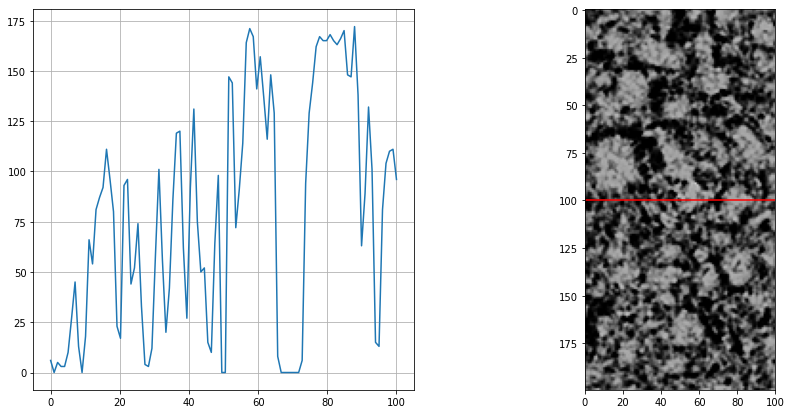

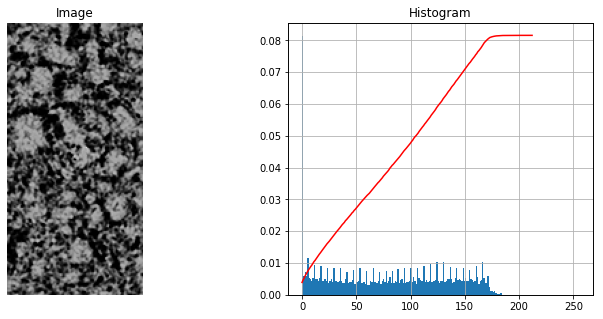

In [ ]:
im_obj = ImageProcess(im_eq)
im_impulso = im_obj.aplica_filtro(FILT_3D_IMPULSO)
im_impulso = im_alt_range(im_impulso,0,2**8-1)

im_sec_plot(im_impulso[:,:,50], pos=100, bits=8)
plot_im_hist(im_impulso[:,:,50])

Filtro de Sobel 3D na direção Z

![texto do link](https://wikimedia.org/api/rest_v1/media/math/render/svg/64319ddbc13fe0d98cd04cc6f0bda6cedb3dc0b4)

In [ ]:
FILT_3D_SOBELV = np.array([
          [[1, 2, 1],
           [2, 4, 2],
           [1, 2, 1]],

          [[0, 0, 0],
           [0, 0, 0],
           [0, 0, 0]],

          [[-1, -2, -1],
           [-1, -4, -2],
           [-1, -2, -1]],        
          ])

FILT_3D_SOBELH = FILT_3D_SOBELV.T

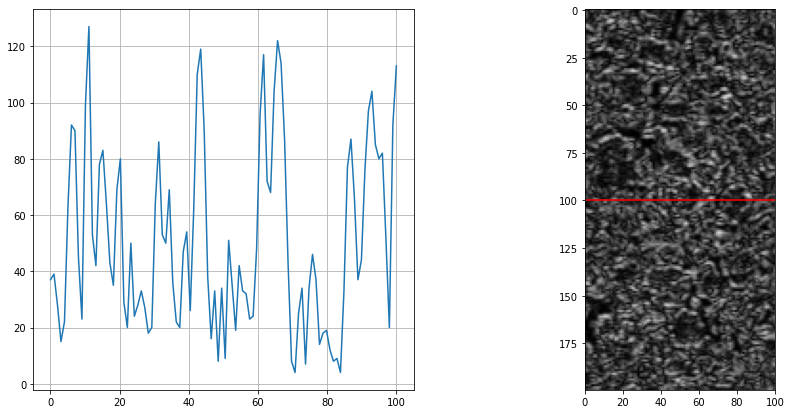

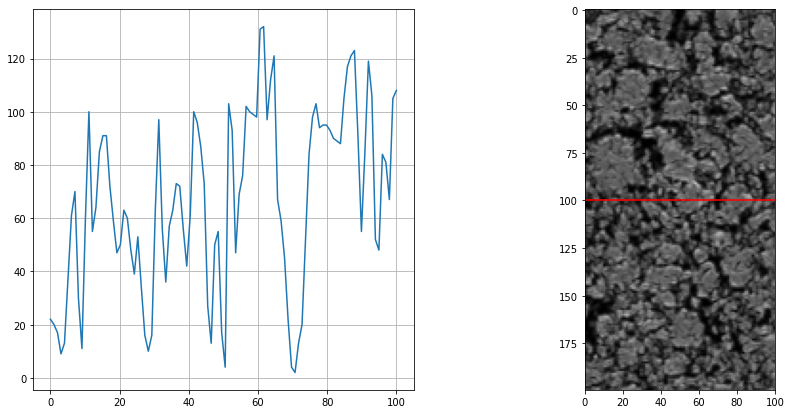

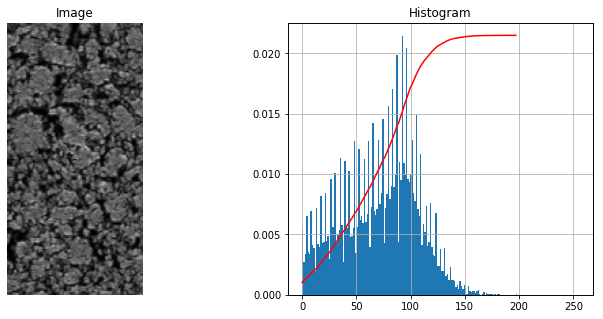

In [ ]:
im_obj = ImageProcess(im_impulso)
im_sobel = abs(im_obj.aplica_filtro(FILT_3D_SOBELV, limita=False)) + abs(im_obj.aplica_filtro(FILT_3D_SOBELH, limita=False))
im_sobel = im_alt_range(im_sobel,0,2**8-1)
im_sec_plot(im_sobel[:,:,50], pos=100, bits=8)

im_ = im_alt_range(im_impulso + im_sobel, 0, 2**8-1)
im_sec_plot(im_[:,:,50], pos=100, bits=8)
plot_im_hist(im_[:,:,50])

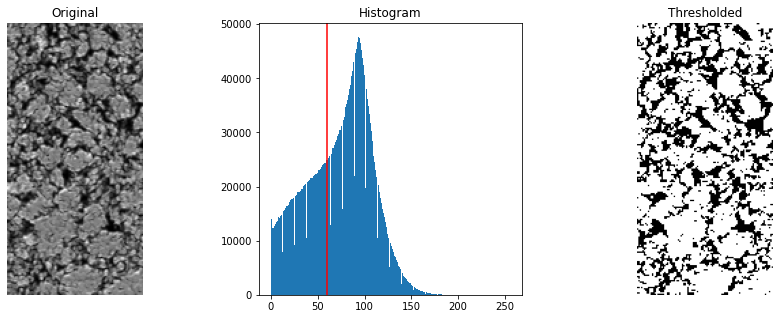

In [ ]:
im_seg = im_.copy()
lim = 60
im_seg[im_seg < lim] = 0
im_seg[im_seg >= lim] = 1

plot_im(im_, im_seg, lim, 100) 

In [ ]:
print(f"porosidade = {1 - im_seg.ravel().sum()/(im_seg.ravel().shape)}")

porosidade = [0.3406525]


In [ ]:
%%capture
!pip install porespy 
import porespy as ps 

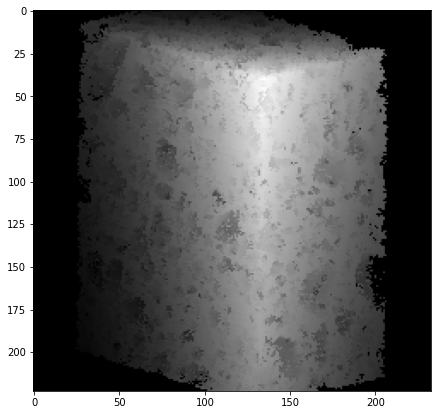

In [ ]:
fig, axes = plt.subplots(ncols = 1, figsize = (21,7))
axes.imshow(ps.visualization.show_3D(im_seg==1), cmap = 'gray');

## 4) 
### a) Obtenha uma imagem CT de cabeça e melhore seu aspecto utilizando composições apropriadas de filtros. Justifique cada passo.


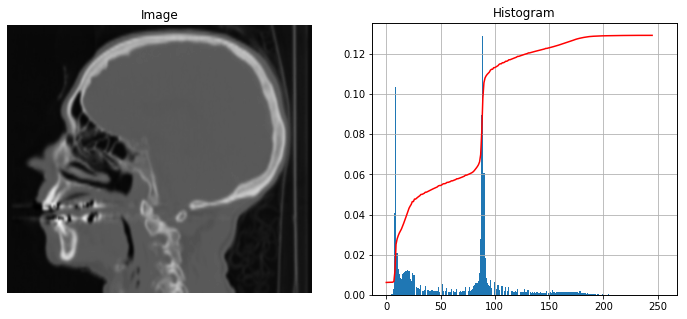

In [ ]:
# importando imagens
from skimage import io
file_ = "/content/drive/My Drive/Classroom/Processamento de Imagens Digitais/Lista 6 - PID/Lista 6/images/CT_Sagital.jpg"
im_ctsag = (io.imread(file_,as_gray=True)*255).astype(int)
plot_im_hist(im_ctsag)

Inicialmente será aplicado um filtro de mediana com kernel circular de raio 5.
O objetivo é remover os pixeis extremos dentro da imagem.

/usr/local/lib/python3.6/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)


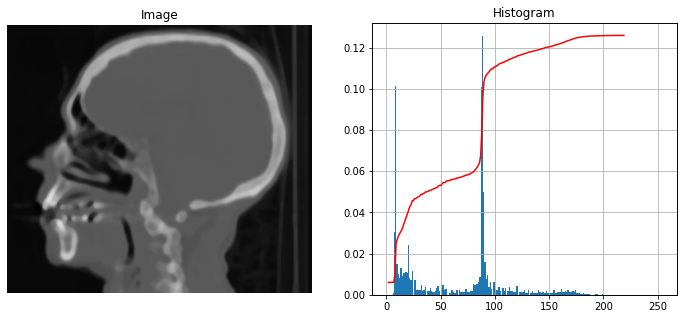

In [ ]:
from skimage.morphology import disk, square
from skimage.filters import rank

selem = disk(5)
im_med = rank.median(im_ctsag, selem=selem)
plot_im_hist(im_med)

Agora será aplicado um filtro laplaciano de subtração para retirar os detalhes do fundo.

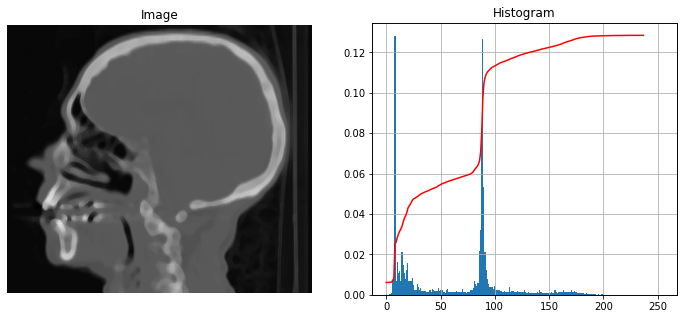

In [ ]:
im_pr = ImageProcess(im_med)
im_sub = (im_pr.aplica_filtro(FILT_ADD)*255).astype(int)
plot_im_hist(im_sub)

Agora serão retirado os pixeis menores que 35

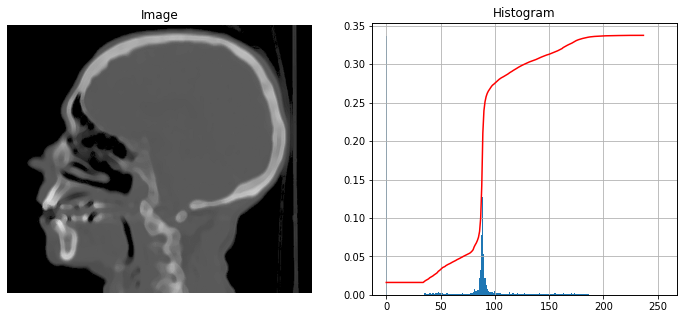

In [ ]:
im_cort = im_sub.copy()
im_cort[im_cort<35] = 0
plot_im_hist(im_cort)

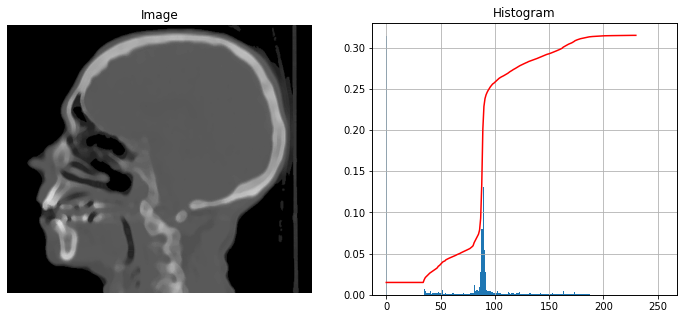

In [ ]:
im_adapmed = (AdaptiveMedianFilter(im_cort,s=3,sMax=25)).astype(int)
plot_im_hist(im_adapmed)

Agora será aplicada uma segmentação para os pixeis menores que 50 e maiores que 100


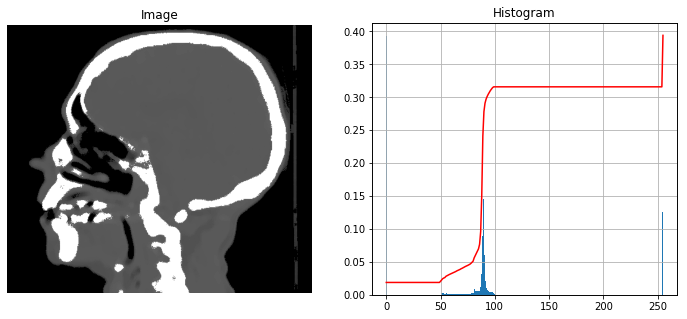

In [ ]:
im_seg = im_adapmed.copy()
im_seg[im_seg<50] = 0
im_seg[im_seg>=100] = 255
plot_im_hist(im_seg)

será aplicado o filtro de Sobel para retirar os detalhes

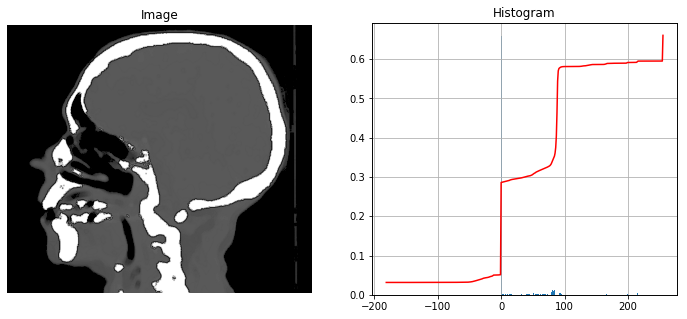

In [ ]:
from skimage import filters

im_sobel = filters.sobel(im_seg/255)
im_sub_sobel = (im_seg - 255*im_sobel).astype(int)
plot_im_hist(im_sub_sobel)

Por fim, é seguimentada a imagem em 4 valores e aplicado filtro de mediana adaptavel. Nota-se que o fundo foi totalmente removido.

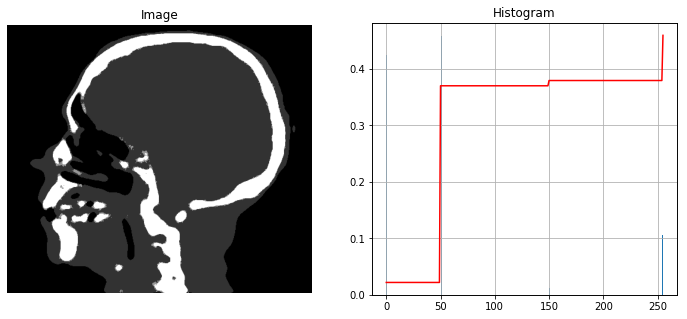

In [ ]:
im_seg_2 = im_sub_sobel.copy()

im_seg_2[im_seg_2<50] = 0
im_seg_2[ ((im_seg_2<150) & (im_seg_2>50)) ] = 50
im_seg_2[((im_seg_2>150) & (im_seg_2<200)) ] = 150
im_seg_2[im_seg_2>200] = 255

im_adapmed_2 = (AdaptiveMedianFilter(im_seg_2,s=3,sMax=9)).astype(int)
plot_im_hist(im_adapmed_2)    

### b) Repita o item a para uma imagem MRI.

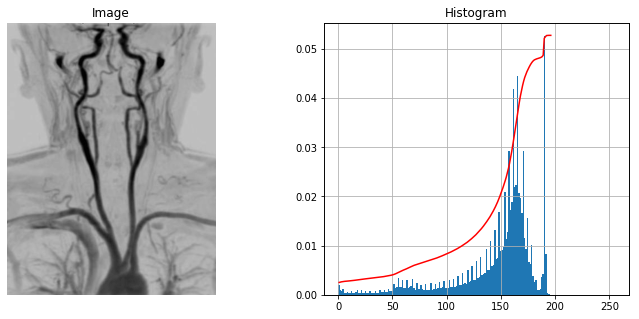

In [ ]:

from urllib.request import urlopen
from PIL import Image
from skimage import color

# url da imagem utilizada
url = "https://upload.wikimedia.org/wikipedia/commons/3/38/Mra1.jpg"
img = np.array(Image.open(urlopen(url)))
img = (255*color.rgb2gray(img)).astype(int)
img = img[10:500,75:450]
plot_im_hist(img)

Primeiro será aplicado o efeito negativo a imagem

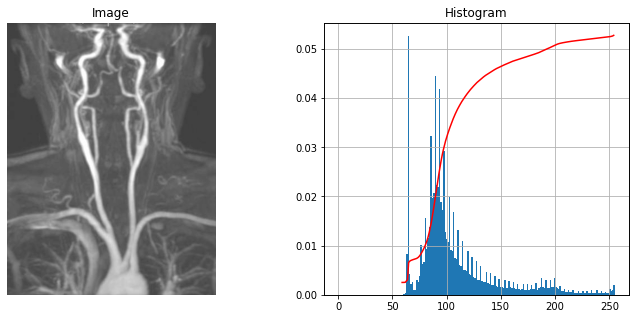

In [ ]:
img_neg = 255 - img
plot_im_hist(img_neg)

Será aplicado o filtro sobel para remoção de detalhes ruidosos

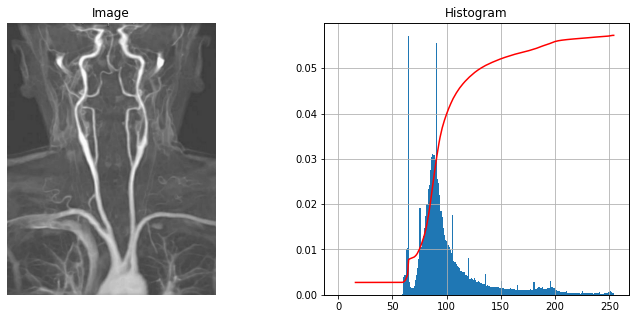

In [ ]:
from skimage import filters

im_sobel = filters.sobel(img_neg/255)
im_sub_sobel = (img_neg - 255*im_sobel).astype(int)
plot_im_hist(im_sub_sobel)

Será aplicado o filtro mediana para remoção de extremos.

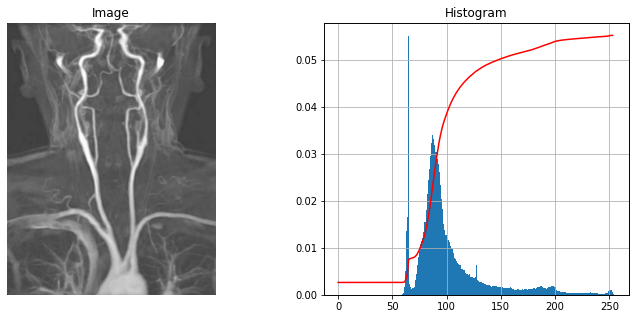

In [ ]:
im_adapmed = (AdaptiveMedianFilter(im_sub_sobel,s=3,sMax=25)).astype(int)
plot_im_hist(im_adapmed)

Será aplicado por último um filtro de impulso para destacar as partes brancas

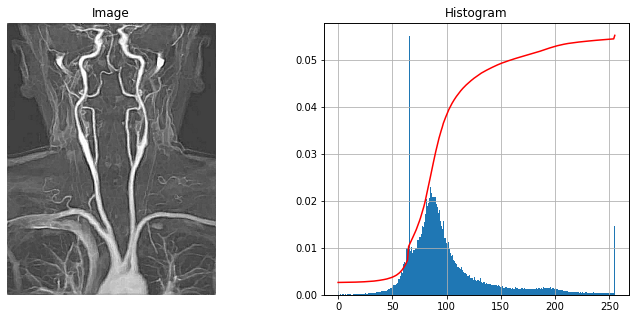

In [ ]:
im_pr = ImageProcess(im_adapmed/255)
im_impulso = (255*im_pr.aplica_filtro(filt_A(1.5))).astype(int)
plot_im_hist(im_impulso)